<a href="https://colab.research.google.com/github/Dealice2003/predicao-despesas-prefeitura/blob/main/Despesas_prefeitura_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 📊 Análise e previsão de Despesas da Prefeitura de Salto Grande/SP

---



Os dados analisados neste projeto foram extraídos do sistema de gestão da Prefeitura Municipal de Salto Grande – SP, Brasil.
A base foi disponibilizada em formato Excel, organizada em planilhas separadas por ano, abrangendo o período de 2020 a 2024.

Para o desenvolvimento da análise e do modelo, foram selecionadas as seguintes colunas principais:

* Ano → Identifica o exercício financeiro correspondente à despesa.

* Texto da Ação de Governo → Descrição da ação governamental vinculada ao gasto.

* Texto do Item do Elemento da Despesa → Detalhamento do item de despesa realizado.

* Aplicação Nome → Nome da aplicação vinculada ao orçamento.

* Data Pagamento → Data em que o pagamento foi efetivado (quando disponível).

* Tipo de Lançamento → Especifica o tipo de movimentação (lançamento, empenho, pagamento, etc.).

* Valor Pago → Valor monetário efetivamente pago em reais (R$).

Estrutura dos Dados

* Total de registros: 279.878 linhas

Tipos de dados:

* object → campos de texto categóricos (Ano, descrições e classificações).

* datetime64[ns] → campo de datas (Data Pagamento).

* float64 → campo numérico contínuo (Valor Pago).

Essa base permite uma visão ampla e detalhada das despesas públicas ao longo de cinco anos, possibilitando análises de tendências, comparações entre ações de governo e identificação de padrões na alocação de recursos.


---



## 🔽 Carregamento e Importação dos Dados


---


Antes de iniciar a modelagem, os dados passaram por um processo de pré-processamento para garantir a qualidade e a consistência necessárias ao projeto.

Inicialmente, os dados estavam organizados em diferentes arquivos .xlsx, um para cada ano de 2020 a 2024. Todos esses arquivos foram consolidados em um único dataset, reunindo os registros em uma tabela unificada.

Durante esse processo, também foi realizada uma seleção de colunas: mantive apenas aquelas consideradas essenciais para a análise e previsão de despesas. As colunas irrelevantes para o objetivo do projeto foram removidas, a fim de facilitar o tratamento e reduzir a complexidade do modelo.

Além disso, linhas vazias ou com campos críticos ausentes, como o valor pago, foram excluídas para evitar distorções nas análises. O resultado final é um conjunto de dados limpo, estruturado e pronto para ser utilizado nas próximas etapas do projeto.(antes de carregar essas colunas em python, algumas colunas ja tinha sido excluidas para otimizar espaço, eram colunas irrelevantes para nosso projeto)

---







In [ ]:
# 📦 1. Importação de Bibliotecas
!pip install -q imbalanced-learn scikit-optimize seaborn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, average_precision_score,
                            precision_recall_curve, roc_curve, PrecisionRecallDisplay)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configurações de estilo
plt.style.use('ggplot')
sns.set_palette("husl")

In [ ]:
# junção das tabelas em um unico conjunto de dados
df1 = pd.read_excel("despesas2020.xlsx")
df2 = pd.read_excel("despesas2021.xlsx")
df3 = pd.read_excel("despesas2022.xlsx")
df4 = pd.read_excel("despesas2023.xlsx")
df5 = pd.read_excel("despesas2024.xlsx")


df_consolidado = pd.concat([df1, df2,df3,df4,df5])
df_consolidado.to_excel("consolidado.xlsx", index=False)

In [ ]:
# Carregar o arquivo Excel
df = pd.read_excel("consolidado.xlsx")

# Remover todas as linhas onde a coluna 'Valor Pago' está vazia
df = df.dropna(subset=["Valor Pago"])

# Salvar o novo arquivo com as linhas limpas
df.to_excel("despesasfinal.xlsx", index=False)

print("Linhas com 'Valor Pago' vazio foram removidas com sucesso.")
print("Arquivo salvo como 'despesasfinal.xlsx'")


Linhas com 'Valor Pago' vazio foram removidas com sucesso.
Arquivo salvo como 'despesasfinal.xlsx'


In [ ]:
# Carregamento dos Dados
df = pd.read_excel("consolidado.xlsx")

# Visualização inicial
print(f"Shape do dataset: {df.shape}")
display(df.head())
display(df.describe())
print("")

# Tipos de informações gerais
# Verificação de nulos e duplicatas

print("Shape do dataset:", df.shape)
print("\nTipos de dados e informações gerais:")
print("")
print(df.info())

Exception ignored in: <function ZipFile.__del__ at 0x7944d694e840>
Traceback (most recent call last):
  File "/usr/lib/python3.12/zipfile/__init__.py", line 1953, in __del__
    self.close()
  File "/usr/lib/python3.12/zipfile/__init__.py", line 1970, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Shape do dataset: (279893, 7)


,Ano,Texto da Ação de Governo,Texto do Item do Elemento da Despesa,Aplicação Nome,Data Pagamento,Tipo de Lançamento,Valor Pago
0,2020,Manutenção Do Centro De Saude - Proprio,"Serviço Médico-Hospitalar, Odontológico E Labo...",Saúde-Geral,NaT,NaN,NaN
1,2020,Manutenção Do Centro De Saude - Proprio,"Serviço Médico-Hospitalar, Odontológico E Labo...",Saúde-Geral,NaT,NaN,NaN
2,2020,Manutenção Do Centro De Saude - Proprio,"Serviço Médico-Hospitalar, Odontológico E Labo...",Saúde-Geral,2020-01-09,PAGAMENTO,400.0
3,2020,Manutenção Do Centro De Saude - Proprio,Juros,Saúde-Geral,NaT,NaN,NaN
4,2020,Manutenção Do Centro De Saude - Proprio,Juros,Saúde-Geral,NaT,NaN,NaN


,Data Pagamento,Valor Pago
count,89212,8.921200e+04
mean,2022-09-30 17:44:44.786799616,2.609126e+03
min,2020-01-02 00:00:00,-1.093384e+05
25%,2021-07-27 00:00:00,1.300000e+02
50%,2022-10-11 00:00:00,3.000000e+02
75%,2023-12-15 00:00:00,1.275870e+03
max,2024-12-30 00:00:00,2.014201e+06
std,NaN,1.425773e+04



Shape do dataset: (279893, 7)

Tipos de dados e informações gerais:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279893 entries, 0 to 279892
Data columns (total 7 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   Ano                                   279878 non-null  object        
 1   Texto da Ação de Governo              271719 non-null  object        
 2   Texto do Item do Elemento da Despesa  271719 non-null  object        
 3   Aplicação Nome                        279875 non-null  object        
 4   Data Pagamento                        89212 non-null   datetime64[ns]
 5   Tipo de Lançamento                    94921 non-null   object        
 6   Valor Pago                            89212 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 14.9+ MB
None


## 📊 Análise Exploratória de Gastos Públicos

📊 ANÁLISE EXPLORATÓRIA DE GASTOS PÚBLICOS

1️⃣ ESTATÍSTICAS DESCRITIVAS DOS VALORES PAGOS
--------------------------------------------------
📈 Período analisado: 02/01/2020 a 30/12/2024
💰 Total gasto: R$ 232,765,328.52
🔢 Número de registros: 89,212
📊 Média: R$ 2,609.13
📉 Mediana: R$ 300.00
⬆️ Máximo: R$ 2,014,200.64
⬇️ Mínimo: R$ -109,338.37
📐 Desvio padrão: R$ 14,257.73
🎯 Coeficiente de variação: 546.5%
↔️ Assimetria: 49.17
📏 Curtose: 5346.60


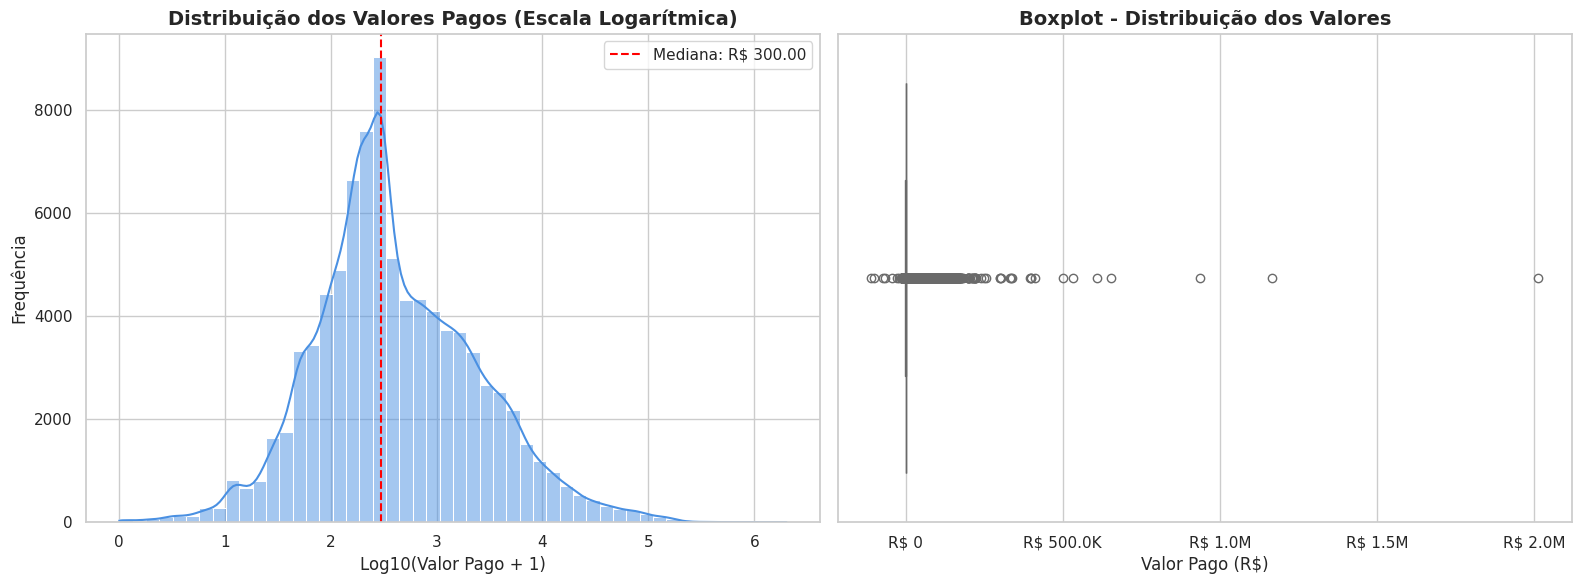


2️⃣ ANÁLISE TEMPORAL DOS GASTOS
--------------------------------------------------


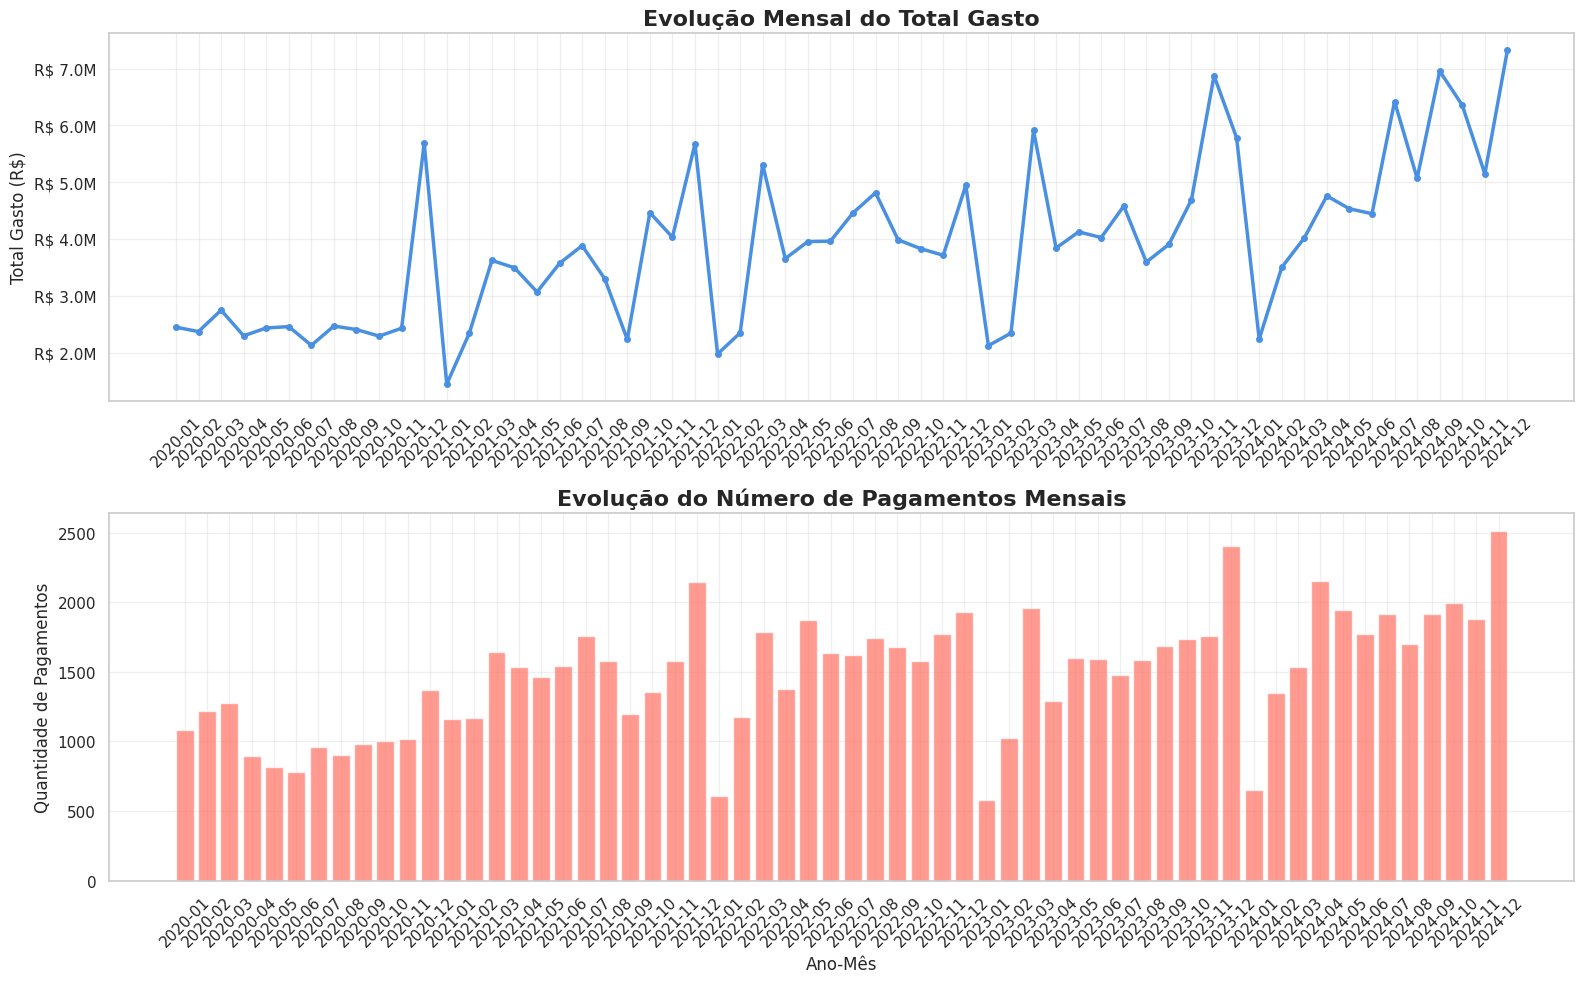

📈 Tendência: Crescimento de 199.4% no período
🔥 Mês de maior gasto: 2024-12 (R$ 7,325,284.41)
📦 Média de pagamentos/mês: 1487

3️⃣ TOP 10 AÇÕES DE GOVERNO POR GASTO
--------------------------------------------------


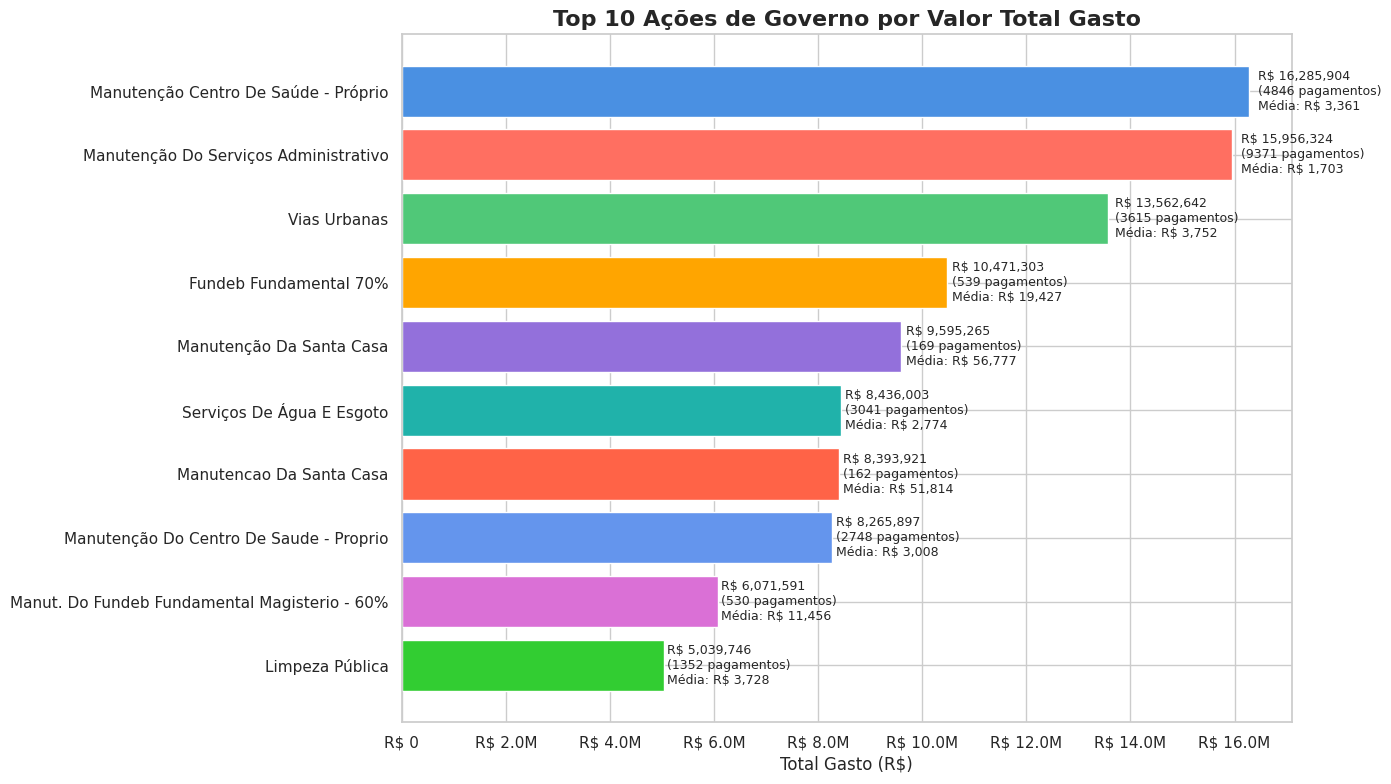

💸 Ação com maior gasto: Manutenção Centro De Saúde - Próprio (R$ 16,285,903.55)
📊 Representatividade do Top 10: 43.9% do total

4️⃣ TOP 10 TIPOS DE DESPESA
--------------------------------------------------


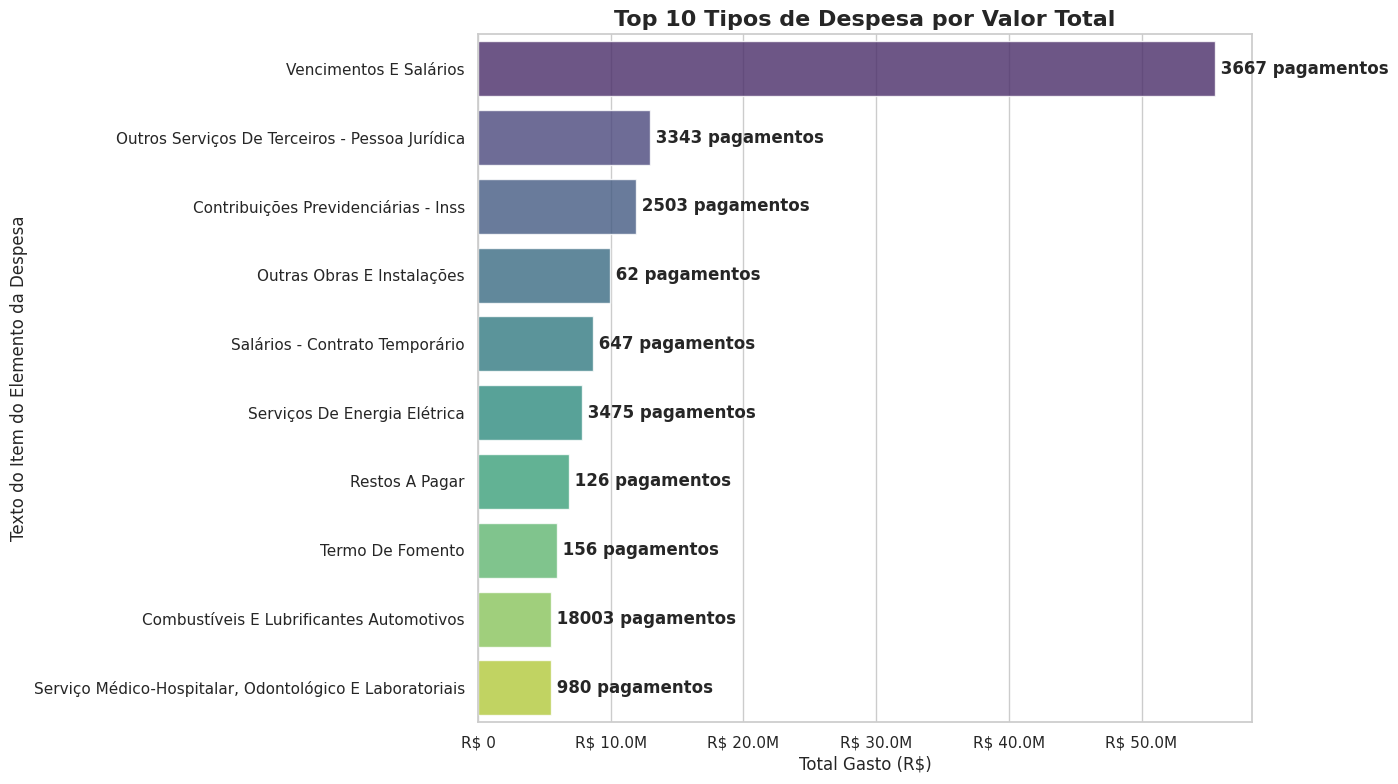


5️⃣ TOP 10 ÁREAS POR GASTO
--------------------------------------------------


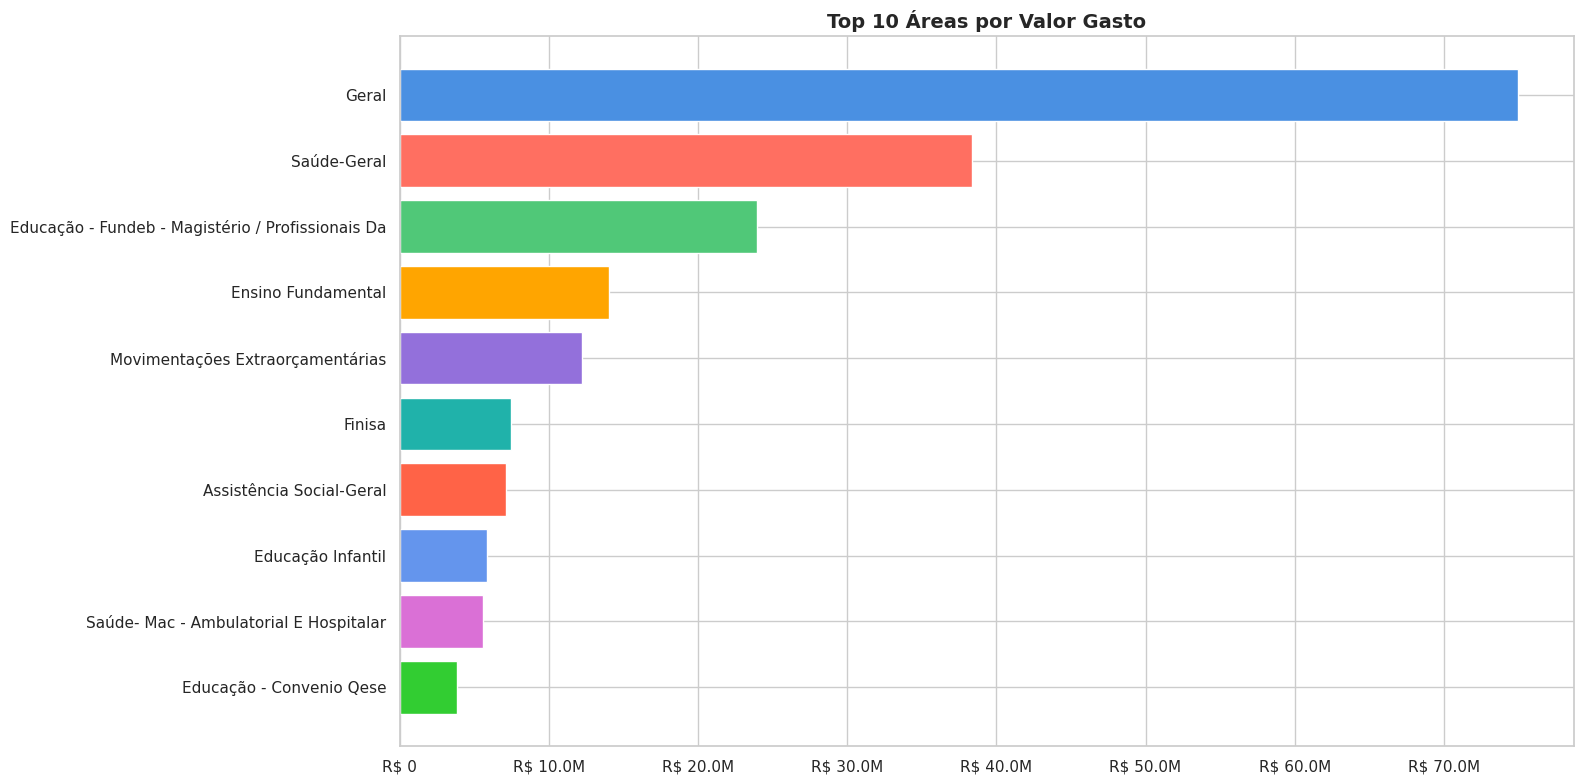

🏷️ Mini-relatório - Áreas (Aplicação Nome):
→ Área com maior gasto: Geral
→ Valor: R$ 74,972,359.81
→ Total das 10 maiores áreas: R$ 193,433,275.75

6️⃣ ANÁLISE DE CONCENTRAÇÃO (PRINCÍPIO DE PARETO)
--------------------------------------------------


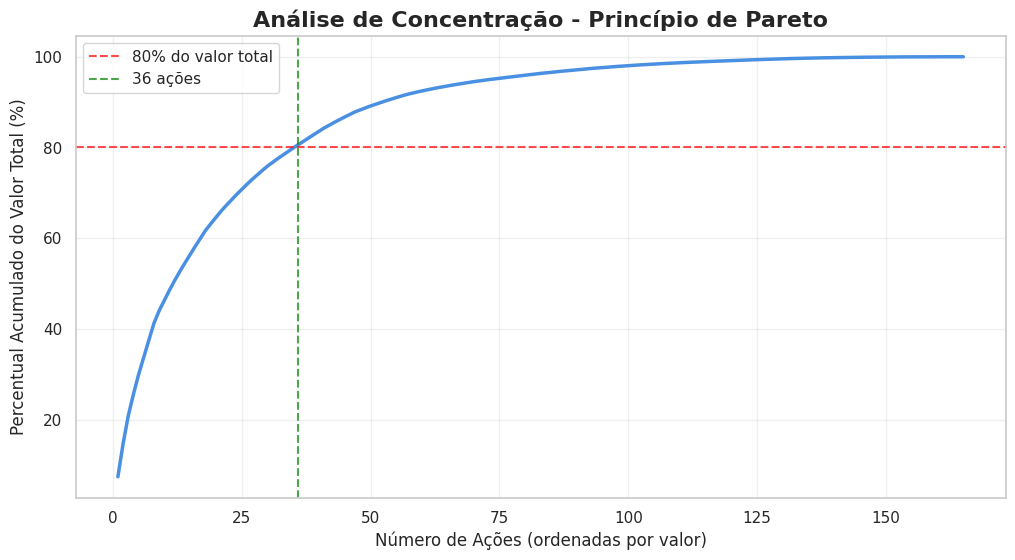

📌 36 ações concentram 80% do valor total gasto
📋 Isso representa 21.8% do total de ações

🎯 RESUMO EXECUTIVO
💡 Principais insights:
• Total analisado: R$ 232,765,328.52
• Período: 02/01/2020 a 30/12/2024
• Média de gasto por transação: R$ 2,609.13
• Concentração: 36 ações representam 80% do valor total
• Área com maior gasto: Geral (R$ 74,972,359.81)
• Tipo de despesa predominante: Vencimentos E Salários
• Tendência temporal: Crescimento de 199.4%


In [ ]:
from matplotlib.ticker import FuncFormatter

# Configurações estéticas
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['font.size'] = 12
colors = ['#4A90E2', '#FF6F61', '#50C878', '#FFA500', '#9370DB', '#20B2AA', '#FF6347', '#6495ED', '#DA70D6', '#32CD32']

# Função para formatar valores em reais
def format_currency(x, pos):
    if x >= 1e9:
        return f'R$ {x/1e9:.1f}B'
    elif x >= 1e6:
        return f'R$ {x/1e6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x/1e3:.1f}K'
    else:
        return f'R$ {x:.0f}'

currency_formatter = FuncFormatter(format_currency)

# ========================
# ANÁLISE EXPLORATÓRIA - GASTOS PÚBLICOS
# ========================

print("=" * 60)
print("📊 ANÁLISE EXPLORATÓRIA DE GASTOS PÚBLICOS")
print("=" * 60)

# 1. ESTATÍSTICAS DESCRITIVAS COMPLETAS
print("\n1️⃣ ESTATÍSTICAS DESCRITIVAS DOS VALORES PAGOS")
print("-" * 50)

stats = df["Valor Pago"].describe()
additional_stats = {
    'Soma Total': df["Valor Pago"].sum(),
    'Coeficiente de Variação': (df["Valor Pago"].std() / df["Valor Pago"].mean()) * 100,
    'Assimetria': df["Valor Pago"].skew(),
    'Curtose': df["Valor Pago"].kurtosis()
}

print(f"📈 Período analisado: {df['Data Pagamento'].min().strftime('%d/%m/%Y')} a {df['Data Pagamento'].max().strftime('%d/%m/%Y')}")
print(f"💰 Total gasto: R$ {additional_stats['Soma Total']:,.2f}")
print(f"🔢 Número de registros: {len(df):,}")
print(f"📊 Média: R$ {stats['mean']:,.2f}")
print(f"📉 Mediana: R$ {stats['50%']:,.2f}")
print(f"⬆️ Máximo: R$ {stats['max']:,.2f}")
print(f"⬇️ Mínimo: R$ {stats['min']:,.2f}")
print(f"📐 Desvio padrão: R$ {stats['std']:,.2f}")
print(f"🎯 Coeficiente de variação: {additional_stats['Coeficiente de Variação']:.1f}%")
print(f"↔️ Assimetria: {additional_stats['Assimetria']:.2f}")
print(f"📏 Curtose: {additional_stats['Curtose']:.2f}")

# 2. DISTRIBUIÇÃO DOS VALORES PAGOS (LOG SCALE)
plt.figure(figsize=(16, 6))

# Handle potential negative values before log scaling
positive_values = df[df["Valor Pago"] >= 0]["Valor Pago"]
if not positive_values.empty:
    plt.subplot(1, 2, 1)
    sns.histplot(np.log10(positive_values + 1), bins=50, kde=True, color=colors[0])
    plt.title("Distribuição dos Valores Pagos (Escala Logarítmica)", fontsize=14, fontweight='bold')
    plt.xlabel("Log10(Valor Pago + 1)")
    plt.ylabel("Frequência")
    # Ensure median is calculated on positive values for log scale plot
    median_positive = positive_values.median()
    if not np.isnan(median_positive) and median_positive >= 0:
        plt.axvline(np.log10(median_positive + 1), color='red', linestyle='--', label=f'Mediana: R$ {median_positive:,.2f}')
        plt.legend()
else:
    print("\n⚠️ Skipping log distribution plot: No positive 'Valor Pago' values found.")


plt.subplot(1, 2, 2)
# Handle potential negative values for boxplot
sns.boxplot(x=df["Valor Pago"], color=colors[1])
plt.title("Boxplot - Distribuição dos Valores", fontsize=14, fontweight='bold')
plt.xlabel("Valor Pago (R$)")
plt.gca().xaxis.set_major_formatter(currency_formatter)


plt.tight_layout()
plt.show()

# 3. EVOLUÇÃO TEMPORAL DOS GASTOS
print("\n2️⃣ ANÁLISE TEMPORAL DOS GASTOS")
print("-" * 50)

df["AnoMes"] = df["Data Pagamento"].dt.to_period("M")
gastos_mensais = df.groupby("AnoMes")["Valor Pago"].agg(['sum', 'count', 'mean']).reset_index()
gastos_mensais['AnoMes'] = gastos_mensais['AnoMes'].astype(str)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Evolução do total gasto
ax1.plot(gastos_mensais['AnoMes'], gastos_mensais['sum'], marker='o', linewidth=2.5, color=colors[0], markersize=4)
ax1.set_title("Evolução Mensal do Total Gasto", fontsize=16, fontweight='bold')
ax1.set_ylabel("Total Gasto (R$)")
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(currency_formatter)
ax1.grid(True, alpha=0.3)

# Evolução do número de pagamentos
ax2.bar(gastos_mensais['AnoMes'], gastos_mensais['count'], alpha=0.7, color=colors[1])
ax2.set_title("Evolução do Número de Pagamentos Mensais", fontsize=16, fontweight='bold')
ax2.set_ylabel("Quantidade de Pagamentos")
ax2.set_xlabel("Ano-Mês")
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas temporais
# Check if there's enough data for growth calculation
if len(gastos_mensais) > 1:
    crescimento = ((gastos_mensais['sum'].iloc[-1] - gastos_mensais['sum'].iloc[0]) / gastos_mensais['sum'].iloc[0]) * 100
    print(f"📈 Tendência: {'Crescimento' if crescimento > 0 else 'Queda'} de {abs(crescimento):.1f}% no período")
else:
    print("\n⚠️ Not enough data points to calculate growth trend.")

if not gastos_mensais.empty:
    mes_maior_gasto = gastos_mensais.loc[gastos_mensais['sum'].idxmax()]
    print(f"🔥 Mês de maior gasto: {mes_maior_gasto['AnoMes']} (R$ {mes_maior_gasto['sum']:,.2f})")
    print(f"📦 Média de pagamentos/mês: {gastos_mensais['count'].mean():.0f}")
else:
    print("\n⚠️ Skipping temporal statistics: No monthly expenditure data found.")


# 4. TOP 10 AÇÕES DE GOVERNO
print("\n3️⃣ TOP 10 AÇÕES DE GOVERNO POR GASTO")
print("-" * 50)

# Handle potential NaN values in 'Texto da Ação de Governo' before grouping
df_acoes = df.dropna(subset=["Texto da Ação de Governo"]).copy()
if not df_acoes.empty:
    top_acoes = df_acoes.groupby("Texto da Ação de Governo")["Valor Pago"].agg(['sum', 'count']).sort_values('sum', ascending=False).head(10)

    if not top_acoes.empty:
        top_acoes['avg'] = top_acoes['sum'] / top_acoes['count']

        plt.figure(figsize=(14, 8))
        bars = plt.barh(range(len(top_acoes)), top_acoes['sum'], color=colors[:10])
        plt.gca().invert_yaxis()
        plt.yticks(range(len(top_acoes)), top_acoes.index)
        plt.title("Top 10 Ações de Governo por Valor Total Gasto", fontsize=16, fontweight='bold')
        plt.xlabel("Total Gasto (R$)")
        plt.gca().xaxis.set_major_formatter(currency_formatter)

        # Adicionar valores nas barras
        for i, (valor, count, avg) in enumerate(zip(top_acoes['sum'], top_acoes['count'], top_acoes['avg'])):
            plt.text(valor * 1.01, i, f'R$ {valor:,.0f}\n({count} pagamentos)\nMédia: R$ {avg:,.0f}',
                     va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

        print(f"💸 Ação com maior gasto: {top_acoes.index[0]} (R$ {top_acoes['sum'].iloc[0]:,.2f})")
        print(f"📊 Representatividade do Top 10: {(top_acoes['sum'].sum() / df['Valor Pago'].sum() * 100):.1f}% do total")
    else:
         print("\n⚠️ Skipping Top 10 Ações de Governo: No data found after dropping NaNs.")
else:
    print("\n⚠️ Skipping Top 10 Ações de Governo: No data found after dropping NaNs in 'Texto da Ação de Governo'.")


# 5. TOP 10 TIPOS DE DESPESA
print("\n4️⃣ TOP 10 TIPOS DE DESPESA")
print("-" * 50)

# Handle potential NaN values in 'Texto do Item do Elemento da Despesa' before grouping
df_itens = df.dropna(subset=["Texto do Item do Elemento da Despesa"]).copy()
if not df_itens.empty:
    top_itens = df_itens.groupby("Texto do Item do Elemento da Despesa")["Valor Pago"].agg(['sum', 'count']).sort_values('sum', ascending=False).head(10)

    if not top_itens.empty:
        plt.figure(figsize=(14, 8))
        sns.barplot(x=top_itens['sum'], y=top_itens.index, palette="viridis", alpha=0.8)
        plt.title("Top 10 Tipos de Despesa por Valor Total", fontsize=16, fontweight='bold')
        plt.xlabel("Total Gasto (R$)")
        plt.gca().xaxis.set_major_formatter(currency_formatter)

        # Adicionar anotações
        for i, (valor, count) in enumerate(zip(top_itens['sum'], top_itens['count'])):
            plt.text(valor, i, f' {count} pagamentos', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print("\n⚠️ Skipping Top 10 Tipos de Despesa: No data found after dropping NaNs.")
else:
    print("\n⚠️ Skipping Top 10 Tipos de Despesa: No data found after dropping NaNs in 'Texto do Item do Elemento da Despesa'.")


# 6. TOP 10 ÁREAS (APLICAÇÃO NOME)
print("\n5️⃣ TOP 10 ÁREAS POR GASTO")
print("-" * 50)

# Handle potential NaN values in 'Aplicação Nome' before grouping
df_aplicacoes = df.dropna(subset=["Aplicação Nome"]).copy()
if not df_aplicacoes.empty:
    top_aplicacoes = df_aplicacoes.groupby("Aplicação Nome")["Valor Pago"].agg(['sum', 'count']).sort_values('sum', ascending=False).head(10)

    if not top_aplicacoes.empty:
        fig, (ax1) = plt.subplots(1,figsize=(16, 8))

        # Gráfico de barras
        ax1.barh(range(len(top_aplicacoes)), top_aplicacoes['sum'], color=colors)
        ax1.invert_yaxis()
        ax1.set_yticks(range(len(top_aplicacoes)))
        ax1.set_yticklabels(top_aplicacoes.index)
        ax1.set_title("Top 10 Áreas por Valor Gasto", fontsize=14, fontweight='bold')
        ax1.xaxis.set_major_formatter(currency_formatter)

        plt.tight_layout()
        plt.show()

        print("🏷️ Mini-relatório - Áreas (Aplicação Nome):")
        print("→ Área com maior gasto:", top_aplicacoes.index[0])
        print(f"→ Valor: R$ {top_aplicacoes['sum'].iloc[0]:,.2f}")
        print("→ Total das 10 maiores áreas:", f"R$ {top_aplicacoes['sum'].sum():,.2f}")


# 7. ANÁLISE DE CONCENTRAÇÃO (PARETO)
print("\n6️⃣ ANÁLISE DE CONCENTRAÇÃO (PRINCÍPIO DE PARETO)")
print("-" * 50)

# Calculate cumulative for actions of government
# Handle potential NaN values in 'Texto da Ação de Governo' before grouping
df_acoes_pareto = df.dropna(subset=["Texto da Ação de Governo", "Valor Pago"]).copy()
if not df_acoes_pareto.empty:
    acoes_ordenadas = df_acoes_pareto.groupby("Texto da Ação de Governo")["Valor Pago"].sum().sort_values(ascending=False)

    if not acoes_ordenadas.empty:
        acoes_ordenadas_cumsum = acoes_ordenadas.cumsum() / acoes_ordenadas.sum() * 100

        # Encontrar ponto onde 80% do valor é alcançado
        ponto_80 = np.where(acoes_ordenadas_cumsum >= 80)[0]
        if ponto_80.size > 0:
            ponto_80 = ponto_80[0] + 1
            percentual_acoes_80 = (ponto_80 / len(acoes_ordenadas)) * 100

            plt.figure(figsize=(12, 6))
            plt.plot(range(1, len(acoes_ordenadas_cumsum) + 1), acoes_ordenadas_cumsum, linewidth=2.5, color=colors[0])
            plt.axhline(80, color='red', linestyle='--', alpha=0.7, label='80% do valor total')
            plt.axvline(ponto_80, color='green', linestyle='--', alpha=0.7, label=f'{ponto_80} ações')
            plt.xlabel("Número de Ações (ordenadas por valor)")
            plt.ylabel("Percentual Acumulado do Valor Total (%)")
            plt.title("Análise de Concentração - Princípio de Pareto", fontsize=16, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

            print(f"📌 {ponto_80} ações concentram 80% do valor total gasto")
            print(f"📋 Isso representa {percentual_acoes_80:.1f}% do total de ações")
        else:
            print("\n⚠️ Skipping Pareto Analysis: 80% concentration point not reached with available data.")
    else:
        print("\n⚠️ Skipping Pareto Analysis: No data found after grouping actions.")
else:
    print("\n⚠️ Skipping Pareto Analysis: No data found after dropping NaNs in 'Texto da Ação de Governo' or 'Valor Pago'.")


# 8. RESUMO EXECUTIVO
print("\n" + "=" * 60)
print("🎯 RESUMO EXECUTIVO")
print("=" * 60)

# Check if there's data for summary
if not df.empty:
    print(f"💡 Principais insights:")
    print(f"• Total analisado: R$ {df['Valor Pago'].sum():,.2f}")
    # Ensure date range is valid
    if not df['Data Pagamento'].empty and pd.notna(df['Data Pagamento'].min()) and pd.notna(df['Data Pagamento'].max()):
        print(f"• Período: {df['Data Pagamento'].min().strftime('%d/%m/%Y')} a {df['Data Pagamento'].max().strftime('%d/%m/%Y')}")
    else:
        print("• Período: Data range not available")

    if not stats.empty:
        print(f"• Média de gasto por transação: R$ {stats['mean']:,.2f}")
    else:
        print("• Média de gasto por transação: Not available")

    if 'ponto_80' in locals():
        print(f"• Concentração: {ponto_80} ações representam 80% do valor total")
    else:
         print("• Concentração: Not calculated (Pareto analysis skipped)")

    if not top_aplicacoes.empty:
        print(f"• Área com maior gasto: {top_aplicacoes.index[0]} (R$ {top_aplicacoes['sum'].iloc[0]:,.2f})")
    else:
        print("• Área com maior gasto: Not available")

    if not top_itens.empty:
        print(f"• Tipo de despesa predominante: {top_itens.index[0]}")
    else:
        print("• Tipo de despesa predominante: Not available")

    if 'crescimento' in locals():
        print(f"• Tendência temporal: {'Crescimento' if crescimento > 0 else 'Queda'} de {abs(crescimento):.1f}%")
    else:
        print("• Tendência temporal: Not calculated (Temporal analysis skipped)")
else:
    print("\n⚠️ Skipping Executive Summary: No data available in the DataFrame.")


# 📊 Aplicação de Modelos Preditivos para Prever Despesas Futuras  

## 1. Instalação e Importação de Bibliotecas  
Nesta etapa são instaladas e importadas as bibliotecas necessárias para análise de dados, visualização e modelagem preditiva, como **Pandas, NumPy, Scikit-learn, ARIMA, Prophet e Random Forest**.  

## 2. Carregamento e Preparação dos Dados  
As planilhas anuais (2020 a 2024) são consolidadas em um único dataset. Em seguida, realiza-se a limpeza de valores nulos e inconsistências, garantindo a qualidade do conjunto de dados antes da análise.  

## 3. Análise Exploratória  
São gerados gráficos e estatísticas para compreender melhor o comportamento das despesas ao longo do tempo, identificando padrões, sazonalidades e possíveis outliers que podem impactar os modelos.  

## 4. Pré-processamento  
Inclui transformações nos dados, criação ou ajuste de variáveis e preparação final do dataset para aplicação nos algoritmos de previsão.  

## 5. Modelagem Preditiva  
Nesta fase são aplicados diferentes algoritmos de aprendizado de máquina e séries temporais:  
- **Random Forest Regressor**: modelo baseado em árvores de decisão para prever valores contínuos.  
- **ARIMA**: modelo estatístico de séries temporais para capturar tendências e sazonalidades.  
- **Prophet**: algoritmo desenvolvido pelo Facebook para previsões em séries temporais com sazonalidade.  

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Carregamento dos dados tratados
df = pd.read_excel("despesasfinal.xlsx")
df["Data Pagamento"] = pd.to_datetime(df["Data Pagamento"])
df["AnoMes"] = df["Data Pagamento"].dt.to_period("M").dt.to_timestamp()

# Série mensal total
serie_total = df.groupby("AnoMes")["Valor Pago"].sum().reset_index()
cutoff = serie_total["AnoMes"].max() - pd.DateOffset(months=6)
treino = serie_total[serie_total["AnoMes"] <= cutoff]
teste = serie_total[serie_total["AnoMes"] > cutoff]

# ARIMA
arima_model = ARIMA(treino["Valor Pago"], order=(1, 1, 1)).fit()
arima_pred = arima_model.forecast(steps=6).values

# Prophet
prophet_df = treino.rename(columns={"AnoMes": "ds", "Valor Pago": "y"})
prophet = Prophet()
prophet.fit(prophet_df)
futuro = prophet.make_future_dataframe(periods=6, freq='M')
forecast = prophet.predict(futuro)
prophet_pred = forecast.iloc[-6:]["yhat"].values

# Random Forest
def criar_features(data):
    data["ano"] = data["AnoMes"].dt.year
    data["mes"] = data["AnoMes"].dt.month
    return data

rf_train = criar_features(treino.copy())
rf_test = criar_features(teste.copy())
X_train = rf_train[["ano", "mes"]]
y_train = rf_train["Valor Pago"]
X_test = rf_test[["ano", "mes"]]
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Função para avaliação dos modelos
def avaliar(y_true, y_pred, modelo_nome):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return {
        "Modelo": modelo_nome,
        "MAE": f"R$ {mae:,.2f}",
        "RMSE": f"R$ {rmse:,.2f}",
        "R²": f"{r2:.2%}",
        "Erro Médio Absoluto": f"R$ {mae:,.2f}",
        "Erro Quadrático Médio": f"R$ {rmse:,.2f}"
    }

# Avaliação dos modelos
avaliacoes = [
    avaliar(teste["Valor Pago"], arima_pred, "ARIMA"),
    avaliar(teste["Valor Pago"], prophet_pred, "Prophet"),
    avaliar(teste["Valor Pago"], rf_pred, "RandomForest")
]

# Criar DataFrame com as métricas
df_metricas = pd.DataFrame(avaliacoes)
melhor_modelo = df_metricas.loc[df_metricas["RMSE"].str.replace("R$ ", "").str.replace(",", "").astype(float).idxmin()]

# Função para fazer previsões com flexibilidade de datas
def fazer_previsao(modelo_escolhido, data_inicio, meses_a_prever):
    datas_previstas = pd.date_range(start=data_inicio, periods=meses_a_prever, freq='MS')

    if modelo_escolhido == "Prophet":
        futuro = prophet.make_future_dataframe(periods=meses_a_prever, freq='M')
        forecast = prophet.predict(futuro)
        previsoes = forecast.iloc[-meses_a_prever:]["yhat"].values
    elif modelo_escolhido == "ARIMA":
        previsoes = arima_model.forecast(steps=meses_a_prever).values
    else:  # RandomForest
        previsao_df = criar_features(pd.DataFrame({
            "AnoMes": datas_previstas
        }))
        previsoes = rf_model.predict(previsao_df[["ano", "mes"]])

    return datas_previstas, previsoes

# Configuração flexível das previsões (pode ser ajustada)
data_inicio_previsao = teste["AnoMes"].max() + pd.offsets.MonthBegin(1)  # Pode ser ajustada para qualquer data
meses_a_prever = 6  # Pode ser ajustado

# Fazendo as previsões
datas_previstas, previsao_total = fazer_previsao(melhor_modelo["Modelo"], data_inicio_previsao, meses_a_prever)

# Criando DataFrame com os resultados
df_prev = pd.DataFrame({
    "Mês Previsto": datas_previstas,
    "Despesa Estimada": previsao_total
})

# Formatando as datas para exibição
inicio = datas_previstas.min().strftime("%B/%Y")
fim = datas_previstas.max().strftime("%B/%Y")
total_periodo = df_prev["Despesa Estimada"].sum()

# Exibindo os resultados
print("📊 Comparação dos Modelos (Métricas de Desempenho)")
print("="*50)
print(df_metricas.to_string(index=False))
print("\n" + "="*50)
print(f"🏆 Modelo vencedor: {melhor_modelo['Modelo']} (menor RMSE: {melhor_modelo['RMSE']})")
print("="*50 + "\n")

print(f"📅 Previsão de despesas para o período de {inicio} a {fim}:")
print("-"*50)
print(df_prev.to_string(index=False, formatters={"Despesa Estimada": lambda x: f'R$ {x:,.2f}'}))
print("-"*50)
print(f"💰 Total previsto no período: R$ {total_periodo:,.2f}")
print(f"🧠 Modelo selecionado: {melhor_modelo['Modelo']}")
print("-"*50)



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq04z4x7r/xfidc3v6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq04z4x7r/zmktsi2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32355', 'data', 'file=/tmp/tmpq04z4x7r/xfidc3v6.json', 'init=/tmp/tmpq04z4x7r/zmktsi2i.json', 'output', 'file=/tmp/tmpq04z4x7r/prophet_modelitayx3ev/prophet_model-20250918021054.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:10:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📊 Comparação dos Modelos (Métricas de Desempenho)
      Modelo             MAE            RMSE       R² Erro Médio Absoluto Erro Quadrático Médio
       ARIMA R$ 1,876,909.21 R$ 2,059,217.27 -491.06%     R$ 1,876,909.21       R$ 2,059,217.27
     Prophet R$ 1,699,597.84 R$ 1,836,627.55 -370.19%     R$ 1,699,597.84       R$ 1,836,627.55
RandomForest R$ 1,555,395.99 R$ 1,706,538.23 -305.94%     R$ 1,555,395.99       R$ 1,706,538.23

🏆 Modelo vencedor: RandomForest (menor RMSE: R$ 1,706,538.23)

📅 Previsão de despesas para o período de January/2025 a June/2025:
--------------------------------------------------
Mês Previsto Despesa Estimada
  2025-01-01  R$ 2,527,212.42
  2025-02-01  R$ 2,975,374.95
  2025-03-01  R$ 4,552,813.88
  2025-04-01  R$ 4,511,825.81
  2025-05-01  R$ 4,525,816.95
  2025-06-01  R$ 4,469,177.85
--------------------------------------------------
💰 Total previsto no período: R$ 23,562,221.86
🧠 Modelo selecionado: RandomForest
------------------------------------------

## 6. Comparação dos Modelos e Resultados
Os resultados obtidos pelos modelos são comparados a partir de métricas de erro, como **MAE, RMSE e R²**, além de gráficos que mostram a diferença entre valores reais e previstos.  
Apresenta de forma objetiva os principais desempenhos alcançados, destacando qual modelo obteve maior precisão nas previsões.  


In [ ]:
# Dados atualizados
dados = {
    'Mês': ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun'],
    'Previsto': [2570313.72, 3123835.04, 4527658.13, 4516944.27, 4531431.73, 4457428.89],
    'Real':     [2484689.28, 3818685.01, 5861197.67, 4528872.66, 4632134.99, 4439536.36]
}

df = pd.DataFrame(dados)

# Cálculos
df['Diferença (R$)'] = df['Real'] - df['Previsto']
df['Erro (%)'] = ((df['Diferença (R$)']) / df['Previsto']) * 100

# Linha de totais
totais = pd.DataFrame({
    'Mês': ['Total'],
    'Previsto': [df['Previsto'].sum()],
    'Real': [df['Real'].sum()],
    'Diferença (R$)': [df['Diferença (R$)'].sum()],
    'Erro (%)': [(df['Real'].sum() - df['Previsto'].sum()) / df['Previsto'].sum() * 100]
})

df_final = pd.concat([df, totais], ignore_index=True)

# Estilo de exibição
def color_dif(val):
    color = 'green' if val > 0 else 'red'
    return f'color: {color}'

def format_percent(val):
    return f'{val:.2f}%'

styled = df_final.style \
    .format({
        'Previsto': 'R$ {:,.2f}',
        'Real': 'R$ {:,.2f}',
        'Diferença (R$)': 'R$ {:,.2f}',
        'Erro (%)': '{:.2f}%'
    }) \
    .applymap(color_dif, subset=['Diferença (R$)']) \
    .background_gradient(subset=['Erro (%)'], cmap='RdYlGn_r') \
    .set_caption("📊 Tabela Comparativa – Previsão x Real | Jan–Jun/2025") \
    .hide(axis="index")

styled

Mês,Previsto,Real,Diferença (R$),Erro (%)
Jan,"R$ 2,570,313.72","R$ 2,484,689.28","R$ -85,624.44",-3.33%
Fev,"R$ 3,123,835.04","R$ 3,818,685.01","R$ 694,849.97",22.24%
Mar,"R$ 4,527,658.13","R$ 5,861,197.67","R$ 1,333,539.54",29.45%
Abr,"R$ 4,516,944.27","R$ 4,528,872.66","R$ 11,928.39",0.26%
Mai,"R$ 4,531,431.73","R$ 4,632,134.99","R$ 100,703.26",2.22%
Jun,"R$ 4,457,428.89","R$ 4,439,536.36","R$ -17,892.53",-0.40%
Total,"R$ 23,727,611.78","R$ 25,765,115.97","R$ 2,037,504.19",8.59%



---

## ✅ Conclusão

Este notebook mostrou de forma prática como realizar uma análise exploratória em dados de despesas públicas.  
Foram aplicadas etapas de carregamento, limpeza, análise e visualização para facilitar a interpretação e identificar padrões relevantes.

---
